<a href="https://colab.research.google.com/github/drojassa/Optics_Lab/blob/main/DistanciaFocal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

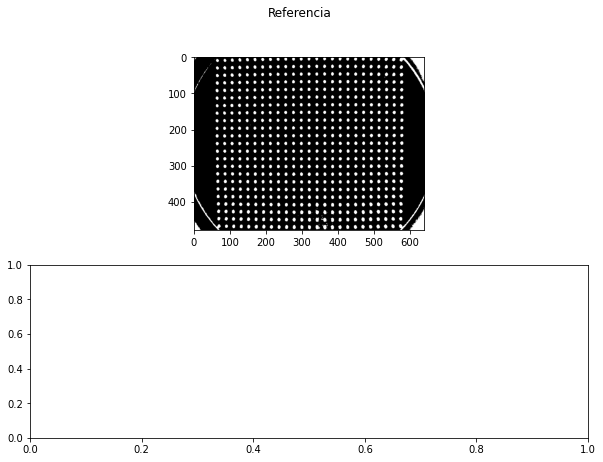

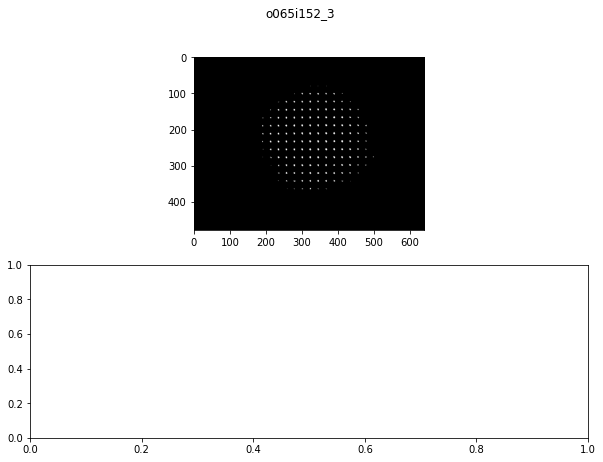

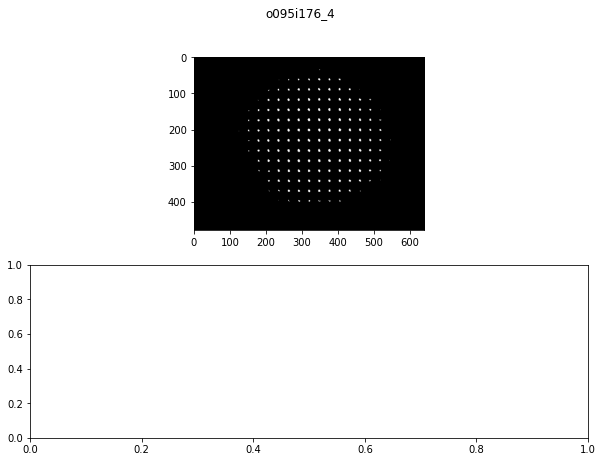

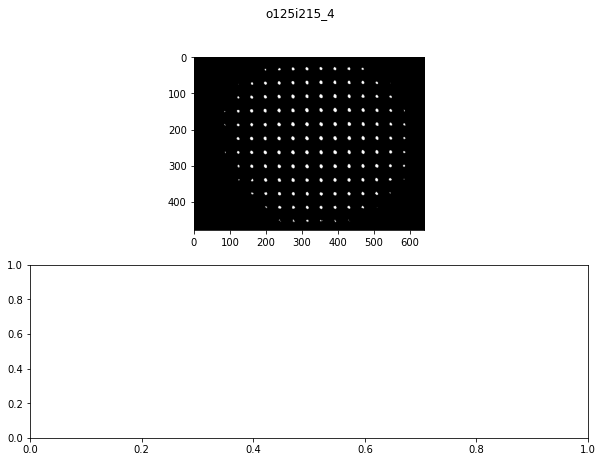

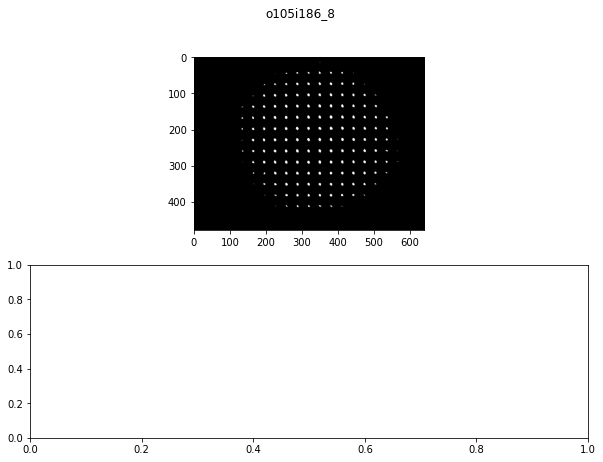

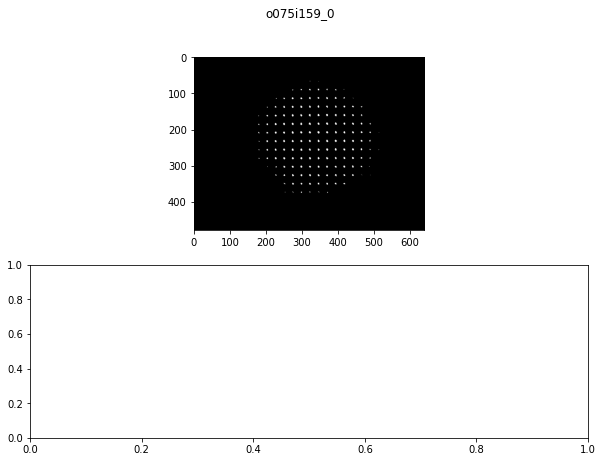

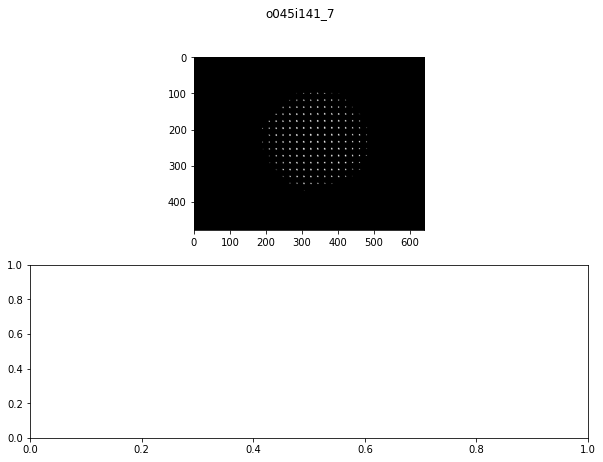

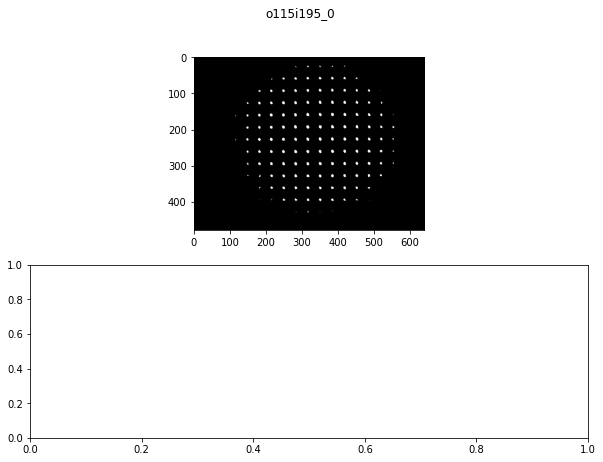

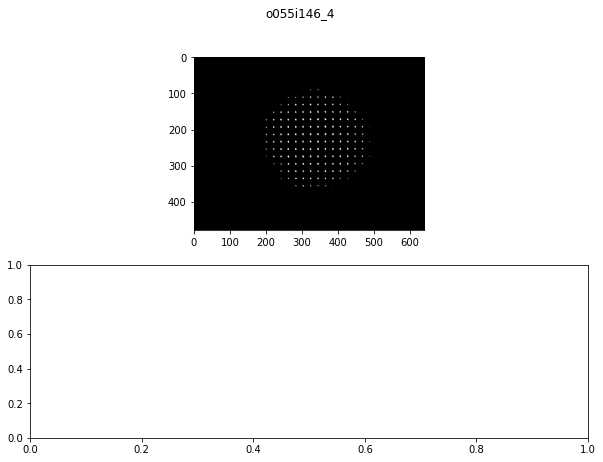

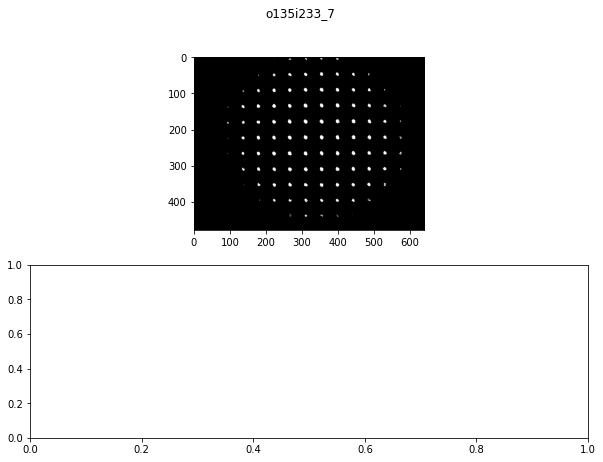

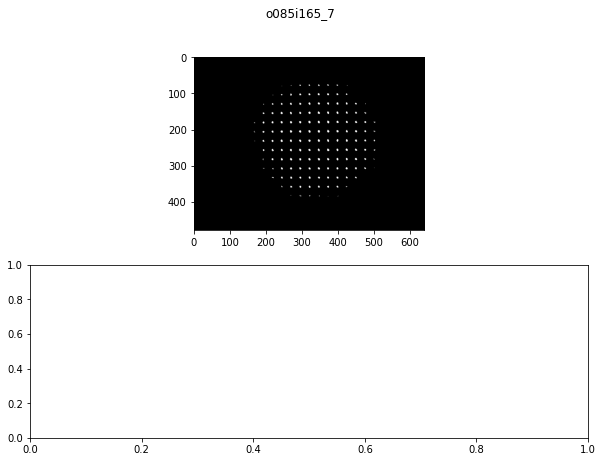

KeyError: ignored

In [ ]:
import pylab as plt
import uncertainties as unc
import numpy as np
import pandas as pd
from os import listdir
from matplotlib.widgets import RectangleSelector
from scipy.ndimage import center_of_mass as COM
from scipy.ndimage import label
from LecturaDatosaCSV import LecturaImagenes

#TODO Deteccion de archivos

def DetecArchivos(Ruta):
    Archivos = [f'{Ruta}/{file}' for file in listdir(Ruta) if '.tif' in file]
    return Archivos

#TODO calcular distancias imagen y objeto reales y distancia focal, nombres

def Distancias(Ruta):
    Archivos = DetecArchivos(Ruta)
    DistObR = unc.ufloat(266.5,0.5)#? Distancia objeto real, referencia, en mm
    DistImR = unc.ufloat(184.5,0.5)#? Distancia imagen real, referencia, en mm
    Dist = {}
    for file in Archivos:
        file = file.replace(Ruta,'').replace('/','').replace('.tif','')
        if file.startswith('o'):
            Dist[file] = {}
            Dist[file]['DistOb'] = unc.ufloat(float(file[1:4]),0.5)#? Distancia objeto ficticia, en mm
            Dist[file]['DistIm'] = unc.ufloat(float(file[5:].replace('_','.')),0.05)#? Distancia Imagen ficticia, en mm
    Dist = pd.DataFrame(Dist).T
    Dist['DistOb'] = DistObR - (Dist['DistOb']- min(Dist['DistOb']))#? Distancias objeto real
    Dist['DistIm'] = DistImR + (Dist['DistIm']- min(Dist['DistIm']))#? Distancias imagen real
    Dist['DistFo'] = 1/(1/Dist['DistOb'] + 1/Dist['DistIm'])
    Dist.to_excel(f'{Ruta}/ResultadosTitulo.xlsx',engine = 'openpyxl')
    return Dist

# Dist = Distancias('ImagenLab/datos')
# print(Dist)

#TODO Calcular distancia de pixeles:



def toggle_selector(event):
    print(' Key pressed.')
    if event.key == 't':
        if toggle_selector.RS.active:
            print(' RectangleSelector deactivated.')
            toggle_selector.RS.set_active(False)
        else:
            print(' RectangleSelector activated.')
            toggle_selector.RS.set_active(True)

s = [[1]*3]*3

def DistPixeles(Ruta):
    Archivos = DetecArchivos(Ruta)
    Data = {}
    for file in Archivos:
        nombre = file.replace(Ruta,'').replace('.tif','')
        nombre = nombre.replace('/','')
        im = plt.imread(file)
        if nombre == 'Referencia':
            im = 255 - im
            im = plt.where(im>210,255,0)
        else:
            im = plt.where(im>50,255,0)
        fig,axes = plt.subplots(2,figsize=(10,7))
        axes[0].imshow(im,cmap = 'gray', vmin=0, vmax=255)
        fig.suptitle(nombre)
        sel = None
        def line_select_callback(eclick, erelease):
            """
            Callback for line selection.

            *eclick* and *erelease* are the press and release events.
            """
            x1, y1 = eclick.xdata, eclick.ydata
            x2, y2 = erelease.xdata, erelease.ydata
            xs = [x1,x2]
            ys = [y1,y2]
            sel = im[int(min(ys)):int(max(ys)),int(min(xs)):int(max(xs))]
            Data[nombre] = {}
            CentrosMasa(Data[nombre],sel)
            axes[1].imshow(sel,cmap = 'gray')
            fig.canvas.draw_idle()
        toggle_selector.RS = RectangleSelector(axes[0], line_select_callback,
                                        drawtype='box', useblit=True,
                                        button=[1, 3],  # disable middle button
                                        minspanx=5, minspany=5,
                                        spancoords='pixels',
                                        interactive=True)
        fig.canvas.mpl_connect('key_press_event', toggle_selector)
        plt.draw()
        plt.pause(10)
        plt.close()
    return Data

#TODO seleccionar centro de masa

def CentrosMasa(Data,sel):
            labs, n = label(sel,structure=s)
            cordy = []
            for i in range(1,n+1):
                y,_ = COM(sel,labs,i)
                cordy.append(y)
            cordy = np.array(cordy)
            dist = []
            for j in range(len(cordy)-1):
                dist.append(np.abs(cordy[j]-cordy[j+1]))
            dist = np.array(dist)
            print(n)
            Data['n'] = n
            Data['dist'] = unc.ufloat(dist.mean(),dist.std())

#TODO calcular distancia focal, imagenes

#? f = -(di)/(m-1) Distancia focal de la lente a partir de ecuación de newton
#? m = hi/ho Magnificacion

def DistanciaFocal(Ruta):
    Dist = Distancias(Ruta)
    Data = DistPixeles(Ruta)
    print(Data['Referencia']['dist'])
    for nombre in Data.keys():
        if nombre != 'Referencia':
            Data[nombre]['dist'] *= 3/Data['Referencia']['dist']#? distancia imagen en milímetros
            Data[nombre]['mag']  = Data[nombre]['dist']/4 #? magnificacion
    Data = pd.DataFrame(Data).T
    Data.dropna(inplace=True)
    Data['foco'] = (Dist['DistIm'])/(1+Data['mag'])
    Data.to_excel(f'{Ruta}/ResultadosImagenes.xlsx',engine = 'openpyxl')
    print(Data)
    LecturaImagenes(Ruta)

DistanciaFocal('datos')